# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## Persiapan

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse

import catboost as cb

Datanya berupa dua kolom, tanggal/waktu dan jumlah pesanan. Tanggal/waktu dapat dibuat menjadi indeks, dan diubah menjadi format pandas `datetime64`.

In [25]:
try:
    df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

In [26]:
df.sort_index(inplace=True)

In [27]:
df.isna().sum()

num_orders    0
dtype: int64

Tidak terdapat nilai missing value.

In [28]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Data akan diringkas menjadi jumlah perjalanan taksi per jam, bukan jumlah perjalanan taksi setiap sepuluh menit, seperti yang terjadi sekarang.

In [30]:
df = df.resample('1H').sum()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Melihat panjang kerangka data sebelum dan sesudah pengambilan sampel ulang, kami pasti memiliki lebih sedikit nilai untuk dikerjakan. Datanya berkisar dari 1 Maret 2018 hingga 31 Agustus 2018. Saya ingin melihat tren umum sepanjang jangka waktu ini, yang dapat saya lakukan melalui paket `statsmodel`. Menggunakan transfrom Fourier melalui paket statsmodel yang sama, saya akan memeriksa musiman selama beberapa hari terakhir sebelum akhir kumpulan data, untuk melihat apakah ada pola pada hari-hari menjelang waktu prediksi.

## Analisis

In [32]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Rides given over time')

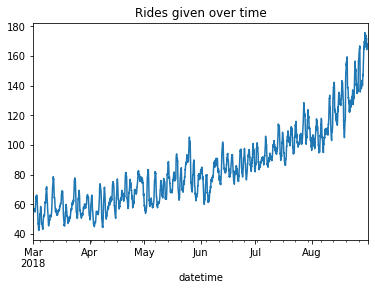

In [33]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Rides given over time')

Jumlah penumpang taksi mencapai titik terendah pada bulan Maret dan secara bertahap meningkat seiring berjalannya waktu. Pada bulan Maret 2018, diberikan antara 40 dan 80 perjalanan per jam, sedangkan pada bulan Agustus 2018, sekitar 100 hingga 180 perjalanan diberikan per jam.

Text(0.5, 1.0, 'Seasonality of rides in late August (Fourier transform)')

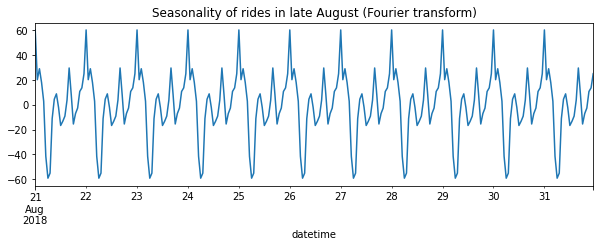

In [34]:
decomposed.seasonal['2018-08-21':'2018-08-31'].plot(figsize=(10,3))
plt.title('Seasonality of rides in late August (Fourier transform)')

Plot musiman ini menunjukkan pola pada hari-hari menjelang jam terakhir dalam kumpulan data. Saat saya mulai membuat fitur, saya perlu mengingat hal ini. Perjalanan taksi tampaknya maksimal pada tengah malam dan minimal beberapa jam setelahnya. Nantinya kita perlu memprediksi jumlah perjalanan dalam satu jam berikutnya, dan plot musiman ini menunjukkan kepada saya bahwa jumlah ini akan lebih tinggi daripada nilai sebelumnya, bukan lebih rendah.

Saya mencari alternatif trigonometri untuk regresi linier karena siklusnya 24 jam, namun saya tidak menemukan opsi yang tersedia. Paling tidak, regressor polinomial seharusnya lebih baik daripada regressor linier, karena trennya terlihat agak melengkung.

Text(0.5, 1.0, 'Residual noise from trends and seasonality')

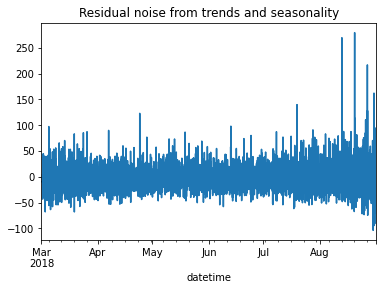

In [35]:
decomposed.resid.plot()
plt.title('Residual noise from trends and seasonality')

Residunya tidak tinggi secara keseluruhan, namun pada bulan Agustus terdapat beberapa residu yang tinggi.

Secara visual, trennya tampaknya meningkat seiring berjalannya waktu, tetapi mari kita gambarkan rata-rata dan deviasi standarnya untuk mendapatkan gambaran yang lebih baik.

<AxesSubplot:xlabel='datetime'>

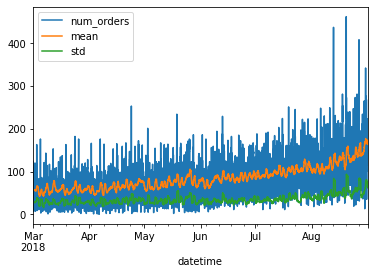

In [36]:
df_plot = df.copy()
df_plot['mean'] = df_plot['num_orders'].rolling(24).mean()
df_plot['std'] = df_plot['num_orders'].rolling(24).std()
df_plot.plot()

Tren kenaikan dari waktu ke waktu, baik mean maupun deviasi standar, dari plot di atas menunjukkan bahwa deret waktu ini merupakan proses stokastik yang tidak stasioner.

Akan ditambahkan beberapa kolom yang datanya tertinggal beberapa jam. Informasi tentang tanggal/waktu dan hari dalam seminggu juga akan berguna, karena informasi ini hanya terdapat dalam indeks dan model dapat menggunakan fitur ini untuk memanfaatkan musiman dalam prediksinya. Fitur dengan rata-rata bergulir dari beberapa jam terakhir juga akan membantu model mengidentifikasi tren.

In [37]:
def lag(df, max_lag):  
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)    
        
def rolling_mean(df, mean_size):
    df['rolling_mean'] = df['num_orders'].shift().rolling(mean_size).mean()

In [38]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

Saya memilih jeda maksimal 6 jam karena seperempat hari dirasa masuk akal untuk memprediksi perjalanan saat ini. Saya memilih rata-rata bergulir 4 karena jumlah perjalanan tampaknya berubah dengan cepat dan saya tidak ingin modelnya melihat terlalu jauh ke masa lalu.

In [39]:
lag(df, max_lag=6)
rolling_mean(df, mean_size=4)

In [40]:
df.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,86.5


Tabelnya terlihat sebagaimana mestinya. Nilai Nan di beberapa baris pertama berarti baris ini harus dihilangkan. Mari kita lakukan ini sebelum kita membagi tabel menjadi beberapa set.

In [41]:
df.dropna(inplace=True)

###  Membuat Prediktif Models

Saya akan mencoba model regresi linier sebagai sanity check, dan juga mencoba regressor polinomial. Selain itu akan dicoba model random forest melalui sklearn dan regressor CatBoost.

Setelah itu dipisah menjadi kumpulan pelatihan, validasi, dan pengujian (dibagi secara kronologis, bukan acak), menggunakan kumpulan validasi untuk menemukan hyperparameter terbaik sebelum melatih model baru pada kumpulan pelatihan + validasi. Lalu akan memilih model terbaik dalam hal RMSE dan menguji kinerja pada set pengujian. Dan akan melatih model pada semua data dan membuat prediksi formal untuk satu jam setelah kumpulan data berakhir.

In [42]:
target = df.num_orders
features = df.drop('num_orders', axis=1)

In [43]:

features_tv, features_test, target_tv, target_test = train_test_split(
    features, target, test_size=1/10, shuffle=False)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_tv, target_tv, test_size=1/9, shuffle=False)

### Linier Regression

In [44]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print('RMSE for training set:', np.sqrt(mse(target_train, pred_train)))
print('RMSE for validation set:', np.sqrt(mse(target_valid, pred_valid)))

RMSE for training set: 28.979309831490838
RMSE for validation set: 40.682839398363036
CPU times: user 6.52 ms, sys: 19.8 ms, total: 26.4 ms
Wall time: 11.9 ms


RMSE untuk set validasi adalah 40,7, yaitu sekitar 35% lebih tinggi dibandingkan RMSE untuk set pelatihan. Modelnya sudah overfitted, tapi tidak keterlaluan.

### Polynomial Regression

In [45]:
for degree in range(1, 5):
    polynomial_trans = PolynomialFeatures(degree=degree)
    features_train_poly = polynomial_trans.fit_transform(features_train)
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(features_train_poly, target_train)
    
    pred_train = poly_reg_model.predict(features_train_poly)
    pred_valid = poly_reg_model.predict(polynomial_trans.fit_transform(features_valid))
    
    print('Degree:', degree)
    print('RMSE for training set:', np.sqrt(mse(target_train, pred_train)))
    print('RMSE for validation set:', np.sqrt(mse(target_valid, pred_valid)))

Degree: 1
RMSE for training set: 28.979309831490838
RMSE for validation set: 40.682839398363036
Degree: 2
RMSE for training set: 25.376287853396484
RMSE for validation set: 39.31335171728364
Degree: 3
RMSE for training set: 21.897243004816268
RMSE for validation set: 52.01150845474393
Degree: 4
RMSE for training set: 17.62340612826726
RMSE for validation set: 146.78943649255322


Model regresi linier dengan prapemrosesan kuadrat (derajat=2) memiliki kinerja sedikit lebih baik dibandingkan regresi linier biasa dengan 1 derajat. Kesenjangan antara RMSE untuk set pelatihan dan set validasi sedikit lebih tinggi, sehingga mungkin lebih cocok dibandingkan model sebelumnya, dan data ini memerlukan transformasi fitur sebelum setiap pelatihan dan prediksi, meskipun tampaknya hampir sama cepatnya. sebagai regresi linier. Saya kira saya akan memilih model ini daripada model regresi linier standar berdasarkan RMSE yang lebih rendah dan biaya tambahan yang minimal.

### Random Forest Regressor

In [46]:
best_est = 0
best_depth = 0
best_model = None
best_rmse = 1e10
current_rmse_train = 0
best_split = 0
best_leaf = 0
for est in [5,9,10,11,15]:
    for depth in range(16,20):
        for samp_split in [2,5,10]:
            for samp_leaf in [1,5,10]:
                model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=0, max_features='sqrt',
                                             min_samples_split=samp_split, min_samples_leaf=samp_leaf)
                model.fit(features_train, target_train)

                pred_valid = model.predict(features_valid)
                rmse_valid = np.sqrt(mse(target_valid, pred_valid))

                pred_train = model.predict(features_train)
                rmse_train = np.sqrt(mse(target_train, pred_train))

                print(est, depth, rmse_valid)
                if rmse_valid < best_rmse:
                    best_rmse = rmse_valid
                    best_model = model
                    best_depth = depth
                    best_est = est
                    current_rmse_train = rmse_train
                    best_split = samp_split
                    best_leaf = samp_leaf
print(f"Number of trees: {best_est}\nMax Depth: {best_depth}\nBest RMSE: {best_rmse}\nTraining RMSE: {current_rmse_train}")
print(f"Min sample split: {best_split}\nMin samples leaf: {best_leaf}")

5 16 37.481449010272144
5 16 37.49257392562935
5 16 39.290315419344
5 16 38.50313257388805
5 16 37.49257392562935
5 16 39.290315419344
5 16 36.28430937637386
5 16 37.49257392562935
5 16 39.290315419344
5 17 36.46471278199076
5 17 36.836500586633385
5 17 39.47543179181662
5 17 36.28576456949499
5 17 36.836500586633385
5 17 39.47543179181662
5 17 37.872115989256244
5 17 36.836500586633385
5 17 39.47543179181662
5 18 35.206762336455476
5 18 37.60282333348899
5 18 39.47543179181662
5 18 36.997700365460105
5 18 37.60282333348899
5 18 39.47543179181662
5 18 38.044816647884915
5 18 37.60282333348899
5 18 39.47543179181662
5 19 36.120020948174776
5 19 37.66430984682493
5 19 39.47543179181662
5 19 37.64422788106118
5 19 37.66430984682493
5 19 39.47543179181662
5 19 36.36349442159569
5 19 37.66430984682493
5 19 39.47543179181662
9 16 35.94374832824287
9 16 37.3071768846874
9 16 38.071557610826424
9 16 37.27150630073563
9 16 37.3071768846874
9 16 38.071557610826424
9 16 35.84607551375971
9 16 37.

RMSE yang divalidasi adalah 34,0, yang jelas lebih rendah dibandingkan model regresi linier. Namun, RMSE ini 3x lipat dari RMSE set pelatihan, yang mengindikasikan overfitting. Model ini akan dilatih dengan cepat hanya dengan 10 pohon dan beberapa ribu titik data.

### Catboost

Saya akan menggunakan evaluator bawaan CatBoost untuk model regresinya dan mencoba hyperparameter yang berbeda. Pertama-tama saya akan menjalankan model dengan beberapa nilai yang masuk akal dengan plot evaluasi bawaan CatBoost dan mengukur berapa banyak penduga yang saya perlukan. Kemudian menemukan nilai `max_kedalaman` yang bagus, dan setelah itu saya akan mengerjakan hyperparameter yang mungkin membantu mengatasi overfitting. Lalu mengubah kecepatan pembelajaran dan jumlah estimator secara bersamaan untuk melihat apakah saya dapat menemukan peningkatan besar, jika tidak, akan menjaga `n_estimator` tetap tinggi.

In [48]:
model_cb = cb.CatBoostRegressor(verbose=100, random_state=0, n_estimators=1588, learning_rate=0.01, max_depth=7, subsample=1,
                                           colsample_bylevel=1, l2_leaf_reg=0)
%time model_cb.fit(features_train, target_train, plot=True, eval_set=(features_valid, target_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 35.5468310	test: 58.0158466	best: 58.0158466 (0)	total: 5.29ms	remaining: 8.39s
100:	learn: 25.7809002	test: 44.3587942	best: 44.3587942 (100)	total: 471ms	remaining: 6.94s
200:	learn: 22.7723454	test: 38.9980892	best: 38.9980892 (200)	total: 960ms	remaining: 6.63s
300:	learn: 21.3064051	test: 36.4829688	best: 36.4829688 (300)	total: 1.44s	remaining: 6.14s
400:	learn: 20.3465743	test: 35.1336729	best: 35.1336729 (400)	total: 1.89s	remaining: 5.61s
500:	learn: 19.5761919	test: 34.3496421	best: 34.3496421 (500)	total: 2.39s	remaining: 5.2s
600:	learn: 18.8930076	test: 33.7593208	best: 33.7593208 (600)	total: 2.86s	remaining: 4.69s
700:	learn: 18.3109544	test: 33.4236614	best: 33.4236614 (700)	total: 3.4s	remaining: 4.31s
800:	learn: 17.7345928	test: 33.1444972	best: 33.1434661 (799)	total: 3.91s	remaining: 3.84s
900:	learn: 17.1957518	test: 32.9355038	best: 32.9355038 (900)	total: 4.48s	remaining: 3.42s
1000:	learn: 16.6631826	test: 32.7767413	best: 32.7741085 (999)	total: 4.94

Setelah mengikuti proses yang saya uraikan di atas model dan menggunakan hyperparameter ini. Dengan RMSE sebesar 32,3, yang sedikit lebih baik dibandingkan dengan Random Forest Regression. Perbedaan RMSE antara set pelatihan dan validasi juga lebih kecil dibandingkan dengan random forest, yang lebih menjanjikan dalam hal overfitting. Pelatihan hanya membutuhkan waktu beberapa detik

### Test Final Model

Menggunakan model CatBoost di sini, karena model tersebut memiliki RMSE terendah dari semua model, pelatihan cepat, dan risiko overfitting yang lebih kecil dibandingkan model dengan kinerja terbaik kedua, random forest. Saya akan melatih model pada set pelatihan + validasi dan menggunakan set pengujian untuk evaluasi akhir.

In [49]:
model_cb = cb.CatBoostRegressor(verbose=100, random_state=0, n_estimators=1588, learning_rate=0.01, max_depth=7, subsample=1,
                                           colsample_bylevel=1, l2_leaf_reg=0)
model_cb.fit(features_tv, target_tv, eval_set=(features_test, target_test))

0:	learn: 38.4711304	test: 84.5543470	best: 84.5543470 (0)	total: 5.65ms	remaining: 8.97s
100:	learn: 27.5684262	test: 65.8461109	best: 65.8461109 (100)	total: 522ms	remaining: 7.68s
200:	learn: 24.1171741	test: 56.1788109	best: 56.1788109 (200)	total: 1.02s	remaining: 7.07s
300:	learn: 22.4886752	test: 51.2777100	best: 51.2777100 (300)	total: 1.54s	remaining: 6.57s
400:	learn: 21.4402705	test: 48.5835041	best: 48.5835041 (400)	total: 2.03s	remaining: 6.02s
500:	learn: 20.6159497	test: 47.2347373	best: 47.2255658 (499)	total: 2.54s	remaining: 5.5s
600:	learn: 19.9265713	test: 46.4536202	best: 46.4512934 (599)	total: 3.04s	remaining: 4.99s
700:	learn: 19.3181367	test: 45.7617078	best: 45.7617078 (700)	total: 3.56s	remaining: 4.5s
800:	learn: 18.7114193	test: 45.2347881	best: 45.2347881 (800)	total: 4.06s	remaining: 3.99s
900:	learn: 18.1650754	test: 44.9117011	best: 44.9117011 (900)	total: 4.55s	remaining: 3.47s
1000:	learn: 17.5902732	test: 44.6351910	best: 44.6296824 (999)	total: 5.05

RMSE akhir yang diuji adalah 43,6, yang jelas berada dalam persyaratan RMSE, meskipun jauh lebih besar daripada RMSE yang divalidasi. Ini mengecewakan tapi jelas bisa diterima. Sekarang saya dapat melatih model ini di seluruh kumpulan data dan membuat perkiraan cakrawala satu langkah, untuk satu jam berikutnya.

In [50]:
model_cb = cb.CatBoostRegressor(verbose=100, random_state=0, n_estimators=1588, learning_rate=0.01, max_depth=7, subsample=1,
                                           colsample_bylevel=1, l2_leaf_reg=0)
model_cb.fit(features, target)

0:	learn: 44.7874073	total: 6.38ms	remaining: 10.1s
100:	learn: 31.0341830	total: 587ms	remaining: 8.65s
200:	learn: 26.5215374	total: 1.13s	remaining: 7.83s
300:	learn: 24.4518301	total: 1.7s	remaining: 7.26s
400:	learn: 23.2144211	total: 2.25s	remaining: 6.65s
500:	learn: 22.3055848	total: 2.8s	remaining: 6.07s
600:	learn: 21.6126214	total: 3.34s	remaining: 5.48s
700:	learn: 20.9753396	total: 3.9s	remaining: 4.94s
800:	learn: 20.3255920	total: 4.45s	remaining: 4.38s
900:	learn: 19.7626449	total: 5.02s	remaining: 3.83s
1000:	learn: 19.2121923	total: 5.57s	remaining: 3.27s
1100:	learn: 18.6585224	total: 6.13s	remaining: 2.71s
1200:	learn: 18.1072336	total: 6.69s	remaining: 2.15s
1300:	learn: 17.6230289	total: 7.25s	remaining: 1.6s
1400:	learn: 17.1640173	total: 7.79s	remaining: 1.04s
1500:	learn: 16.7482083	total: 8.35s	remaining: 484ms
1587:	learn: 16.4282159	total: 8.82s	remaining: 0us


In [51]:
df.tail(5)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,184.25
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,189.25
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,178.50
2018-08-31 22:00:00,223,8,31,22,4,159.0,154.0,136.0,207.0,217.0,197.0,164.00
2018-08-31 23:00:00,205,8,31,23,4,223.0,159.0,154.0,136.0,207.0,217.0,168.00


Untuk membuat pengamatan sendiri satu jam ke depan dan membuat prediksi langsung dari sini. Saya melihat observasi ekor dari kumpulan data untuk mendapatkan informasi ini.

In [52]:
next_observation_features = np.array([9, 1, 0, 5, 205, 223, 159, 154, 136, 207, 174.94])

future_prediction = model_cb.predict(next_observation_features)
print(future_prediction)

222.3769577616068


Dalam satu jam ke depan, diperkirakan ada 222 perjalanan taksi.

## Kesimpulan

Saya diberikan data deret waktu mengenai perjalanan Taksi Sweet Lift, dan menemukan bahwa dari bulan Maret hingga Agustus, jumlah perjalanan per jam umumnya meningkat seiring berjalannya waktu, terendah pada bulan Maret dan tertinggi pada bulan Agustus. Sepanjang hari di akhir Agustus, tampaknya terdapat musim yang dapat diandalkan, dengan jam-jam berbeda dengan puncak perjalanan. Saya melatih model regresi linier dengan urutan yang berbeda-beda, model hutan acak, dan model regresi yang ditingkatkan gradien CatBoost. Model CatBoost memiliki RMSE validasi terbaik, jadi saya memilih model ini untuk diuji sebagai model akhir saya. Root mean squared error yang diuji akhir adalah 43,6 naik taksi, jauh di bawah persyaratan perusahaan yaitu 48 naik taksi. Saya membuat prediksi untuk satu jam ke depan bahwa 217 perjalanan taksi akan dilakukan, yang tampaknya masuk akal mengingat tren masa lalu.

# Daftar Periksa Penilaian

- [x]  Jupyter Notebook bisa dibuka.
- [ ]  Tidak ada kesalahan dalam kode
- [ ]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi.
- [ ]  Data telah diunduh dan disiapkan
- [ ]  Data telah dianalisis
- [ ]  Model sudah dilatih dan hiperparameter sudah dipilih
- [ ]  Model sudah dievaluasi. Kesimpulan sudah ada.
- [ ] *RMSE* untuk *test set* tidak lebih dari 48